<a href="https://colab.research.google.com/github/Jackesgamero/TensorFlow-for-Deep-Learning/blob/master/Fashion-MNIST%20Clohing%20Classifier/Clothes_Image_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalar e importar dependencias



Utilizamos la API TensorFlow Datasets para simplicar el acceso y descarga de conjuntos de datos

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (4.1.0)


In [2]:
import tensorflow as tf

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Importar el conjunto de datos Fashion MNIST


Utilizaremos el conjunto de datos [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), que contiene 70.000 imágenes en escala de grises en 10 categorías. Las imágenes muestran prendas de vestir individuales a baja resolución (28 $\times$ 28 pixels),  como se puede ver aquí:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Usaremos 60.000 imágenes para entrenar la red y 10.000 imágenes para evaluar la precisión con la que la red aprendió a clasificar las imágenes.

In [5]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteDYNX98/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteDYNX98/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


La carga del conjunto de datos devuelve metadatos, así como un conjunto de *datos de entrenamiento* y un conjunto de *datos de prueba*.

* El modelo se entrena usando `train_dataset`.
* El modelo se prueba con `test_dataset`.

Las imágenes son matrices de 28 $\times$ 28, con valores de píxeles en el rango `[0, 255]`. Las *etiquetas* son una matriz de números enteros, en el rango `[0, 9]`. TEstos corresponden a la *clase* de ropa que representa la imagen:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Cada imagen se asigna a una sola etiqueta. Dado que los nombres de las clases no se incluyen con el conjunto de datos, los guardaremos aquí para usarlos más adelante al trazar las imágenes:

In [6]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Explorar datos

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocesar los datos

El valor de cada píxel en los datos de la imagen es un número entero en el rango  `[0,255]`.  Para que el modelo funcione correctamente, estos valores deben normalizarse al rango `[0,1]`. Entonces, aquí creamos una función de normalización y luego la aplicamos a cada imagen en los conjuntos de datos de prueba y entrenamiento.

In [8]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explorar los datos procesados

Trazamos una imagen para ver cómo se ve.

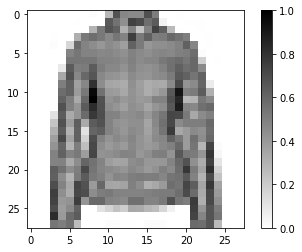

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Mostramos las primeras 25 imágenes del *conjunto de entrenamiento* y el nombre de la clase debajo de cada imagen.

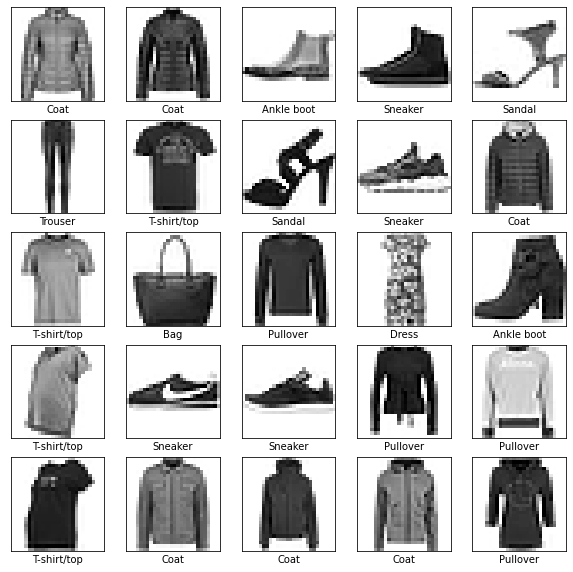

In [10]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(test_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

## Construir modelo 

Configuramos las capas del modelo y lo compilamos

### Configuración de capas



In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Esta red tiene tres capas:

* **entrada** `tf.keras.layers.Flatten` — Esta capa transforma las imágenes de una matriz 2d de 28 $\times$ 28 pixeles, a una matriz 1d de 784 píxeles (28\*28). 

* **"oculta"** `tf.keras.layers.Dense`— Una capa densamente conectada de 128 neuronas. Cada neurona (o nodo) toma la entrada de los 784 nodos de la capa anterior, ponderando esa entrada de acuerdo con los parámetros ocultos que se aprenderán durante el entrenamiento, y envía un valor único a la siguiente capa.

* **salida**  `tf.keras.layers.Dense` — Una capa de 128 neuronas, seguida de una capa *softmax* de 10 nodos. ECada nodo representa una clase de ropa. Como en la capa anterior, la capa final toma la entrada de los 128 nodos de la capa anterior y genera un valor en el rango `[0, 1]`, rque representa la probabilidad de que la imagen pertenezca a esa clase. La suma de los 10 valores de los nodos es 1.

> Nota: La funcion de activacion `softmax` y `SparseCategoricalCrossentropy()` tienen algunos problemas que son corregidos en al modelo `tf.keras`. Una aproximación mas segura, en general, es utilizar una salida lineal (sin función de activación) con `SparseCategoricalCrossentropy(from_logits=True)`.


### Compilar el modelo

Añadimos las métricas, la función de pérdida y la función de optimización


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Entrenar el modelo

Primero, definimos el comportamiento de cada iteración para el conjunto de datos de entrenamiento:
1. Repetir siempre con `dataset.repeat()` (el parámetro `epochs` que aparece más adelante indica cuanto tiempo realizaremos el entrenamiento).
2. `dataset.shuffle(60000)` aleatoriza el orden por lo que nuestro modelo no se puede aprender nada de la orden de los ejemplos.
3. `dataset.batch(32)` indica a `model.fit` que use lotes de 32 imágenes y etiquetas al actualizar las variables del modelo.

El entrenamiento se realiza llamando al método `model.fit`:
1. Utilizamos `train_dataset` como datos de entrenamiento.
2. El parámetro `epochs=5` limita el entrenamiento a 5 iteraciones completas del conjunto de datos de entrenamiento, por lo que un total de 5 * 60000 = 300000 ejemplos.

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4976 - accuracy: 0.8246
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3727 - accuracy: 0.8675
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3353 - accuracy: 0.8774
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3045 - accuracy: 0.8874
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2909 - accuracy: 0.8919


## Evaluar la precisión

Analizamos el rendimiento del modelo en el conjunto de datos de prueba

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3406 - accuracy: 0.8764
Accuracy on test dataset: 0.8763999938964844


## Realizar predicciones


In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [17]:
predictions.shape


(32, 10)

Aqui el modelo indica que la primera imagen del conjunto de prueba ha dado como resultado 32 predicciones con 10 valores cada una (el porcentaje de que sea cada prenda). Echemos un ojo a la primera predicción:

In [18]:
predictions[0]

array([2.8123427e-06, 4.3136282e-07, 4.4510122e-03, 2.0353258e-07,
       9.6200472e-01, 1.4307214e-09, 3.3484034e-02, 8.4665963e-10,
       5.6675141e-05, 6.4934469e-10], dtype=float32)

Una predicción es una matriz de 10 números. Estos describen la "confianza" del modelo en que la imagen corresponde a cada una de las 10 diferentes prendas de vestir. Podemos ver qué etiqueta tiene el valor de confianza más alto:

In [19]:
np.argmax(predictions[0])

4

Podemos graficar esto para ver el conjunto completo de 10 predicciones.

In [20]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Veamos la imagen 0, las predicciones y la matriz de predicciones. 

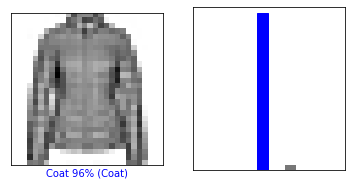

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

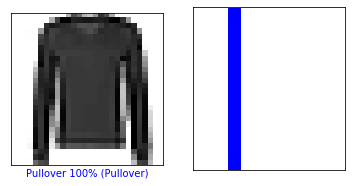

In [22]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Trazamos varias imágenes con sus predicciones. Las etiquetas de predicción correctas son azules y las etiquetas de predicción incorrectas son rojas. El número da el porcentaje (de 100) de la etiqueta predicha. Tenga en cuenta que puede estar mal incluso cuando se tiene mucha confianza.

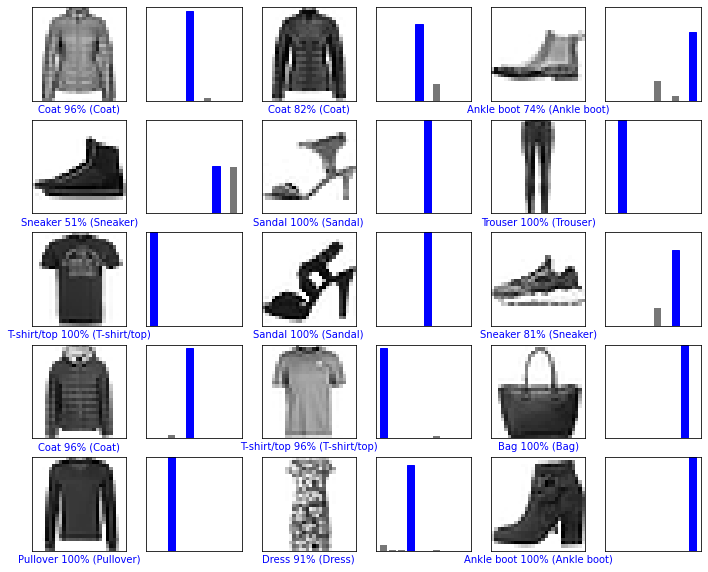

In [23]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Podemos usar el modelo entrenado para hacer una predicción sobre una sola imagen.

In [24]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [25]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [26]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.8123454e-06 4.3136282e-07 4.4510164e-03 2.0353298e-07 9.6200472e-01
  1.4307269e-09 3.3484064e-02 8.4665963e-10 5.6675191e-05 6.4934341e-10]]


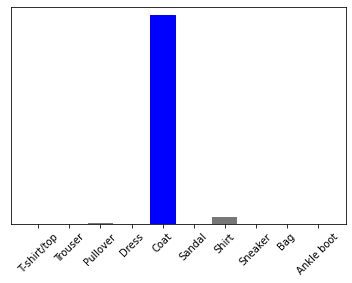

In [27]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [28]:
np.argmax(predictions_single[0])

4